In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
plt.style.use('fivethirtyeight')

# Load dataset


In [2]:
df = pd.read_csv('adolescent#006.csv', index_col=[0], parse_dates=[0])
df = df.iloc[:, [0]]
print(df)

                             BG
Time                           
2023-12-12 00:00:00  134.670000
2023-12-12 00:03:00  134.670000
2023-12-12 00:06:00  134.670000
2023-12-12 00:09:00  134.670000
2023-12-12 00:12:00  134.670000
...                         ...
2023-12-26 23:48:00  116.417591
2023-12-26 23:51:00  116.413009
2023-12-26 23:54:00  116.477419
2023-12-26 23:57:00  116.611788
2023-12-27 00:00:00  116.813233

[7201 rows x 1 columns]


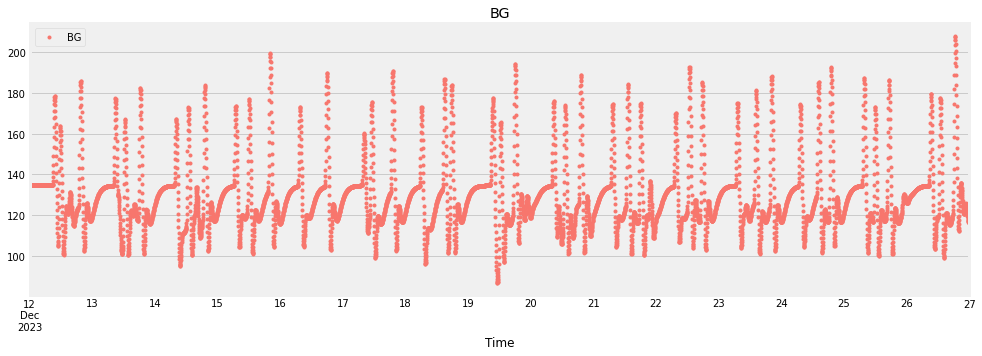

In [3]:
color_pal = ["#F8766D", "#D39200", "#93AA00", "#00BA38", "#00C19F", "#00B9E3", "#619CFF", "#DB72FB"]
_ = df.plot(style='.', figsize=(15,5), color=color_pal[0], title='BG')

# Train/Test Split

In [4]:
split_date = '2023-12-26 23:00:00'
df_train = df.loc[df.index <= split_date].copy()
df_test = df.loc[df.index > split_date].copy()

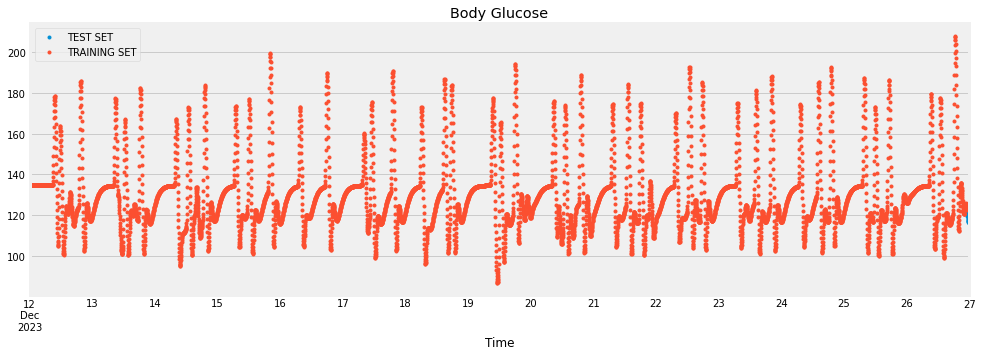

In [5]:
_ = df_test \
    .rename(columns={'BG': 'TEST SET'}) \
    .join(df_train.rename(columns={'BG': 'TRAINING SET'}), how='outer') \
    .plot(figsize=(15,5), title='Body Glucose', style='.')

# Create Time Series Features

In [6]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    df['minute'] = df['date'].dt.minute
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','minute']]
    if label:
        y = df[label]
        return X, y
    return X

In [7]:
X_train, y_train = create_features(df_train, label='BG')
X_test, y_test = create_features(df_test, label='BG')

In [8]:
X_train

,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,minute
Time,,,,,,,,
2023-12-12 00:00:00,0,1,4,12,2023,346,12,0
2023-12-12 00:03:00,0,1,4,12,2023,346,12,3
2023-12-12 00:06:00,0,1,4,12,2023,346,12,6
2023-12-12 00:09:00,0,1,4,12,2023,346,12,9
2023-12-12 00:12:00,0,1,4,12,2023,346,12,12
...,...,...,...,...,...,...,...,...
2023-12-26 22:48:00,22,1,4,12,2023,360,26,48
2023-12-26 22:51:00,22,1,4,12,2023,360,26,51
2023-12-26 22:54:00,22,1,4,12,2023,360,26,54


In [9]:
y_train

Time
2023-12-12 00:00:00    134.670000
2023-12-12 00:03:00    134.670000
2023-12-12 00:06:00    134.670000
2023-12-12 00:09:00    134.670000
2023-12-12 00:12:00    134.670000
                          ...    
2023-12-26 22:48:00    124.580234
2023-12-26 22:51:00    124.139194
2023-12-26 22:54:00    123.655957
2023-12-26 22:57:00    123.140865
2023-12-26 23:00:00    122.603678
Name: BG, Length: 7181, dtype: float64

# Create XGBoost Model

In [10]:
reg = xgb.XGBRegressor(n_estimators=1000, gamma = 0.1)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
       verbose=False) 

c:\Users\Pablo\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\data.py:299: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\Pablo\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\data.py:301: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
c:\Users\Pablo\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\data.py:332: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
c:\Users\Pablo\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\data.py:323: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isins

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0.1, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.300000012, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)

## Feature Importances
Feature importance is a great way to get a general idea about which features the model is relying on most to make the prediction. This is a metric that simply sums up how many times each feature is split on.

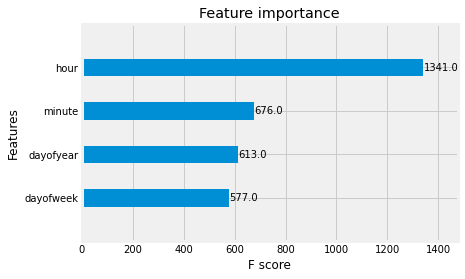

In [11]:
_ = plot_importance(reg, height=0.4)

# Forecast on Test Set

In [12]:
df_test['BG_Prediction'] = reg.predict(X_test)
pjme_all = pd.concat([df_test, df_train], sort=False)

c:\Users\Pablo\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\data.py:299: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\Pablo\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\data.py:301: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
c:\Users\Pablo\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\data.py:332: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
c:\Users\Pablo\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\data.py:323: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isins

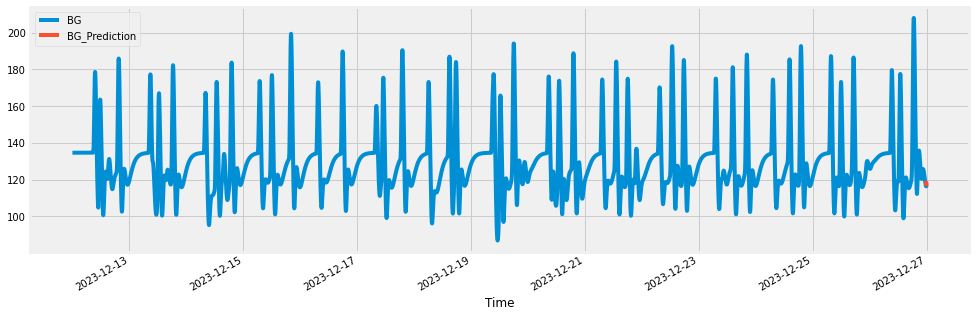

In [13]:
_ = pjme_all[['BG','BG_Prediction']].plot(figsize=(15, 5))

# Look at prediction


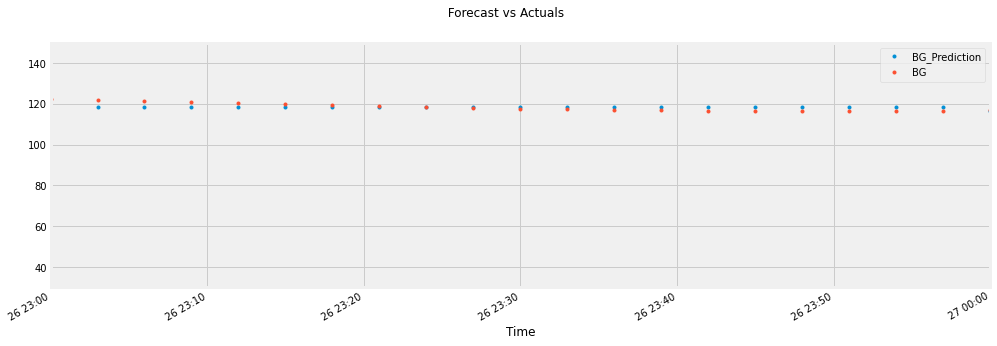

In [14]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = pjme_all[['BG_Prediction','BG']].plot(ax=ax,
                                              style=['.','.'])
ax.set_xbound(lower='2023-12-26 23:00:00', upper='2023-12-27 00:00:00')
ax.set_ylim(30, 150)
plot = plt.suptitle(' Forecast vs Actuals')

# Error Metrics On Test Set


In [15]:
mean_squared_error(y_true=df_test['BG'],
                   y_pred=df_test['BG_Prediction'])

3.232634588499321

In [16]:
mean_absolute_error(y_true=df_test['BG'],
                   y_pred=df_test['BG_Prediction'])

1.5517696229408735

In [17]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [18]:
mean_absolute_percentage_error(y_true=df_test['BG'],
                   y_pred=df_test['BG_Prediction'])

1.307809068299776